In [48]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, log_loss, roc_auc_score, RocCurveDisplay, roc_curve
import wandb
from wandb.sklearn import plot_precision_recall, plot_feature_importances
from wandb.sklearn import plot_class_proportions, plot_learning_curve, plot_roc
import numpy as np
import pandas as pd
from IMPJ import DataProcessor
import random
import matplotlib.pyplot as plt
from os.path import basename, exists
import matplotlib as mpl


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download('https://github.com/AllenDowney/AstronomicalData/raw/main/' + 'az-paper-twocol.mplstyle')
plt.style.use('./az-paper-twocol.mplstyle')

In [49]:
dp = DataProcessor()
test_size = 0.3
n=12
filepath = '..\\Fermi-LAT Data Subsets\\chiaro_12.csv'
datum = pd.read_csv(filepath, index_col=0)
data = pd.read_csv(filepath, index_col=0)
data = data.dropna()
datum = datum.dropna()
X,Y = dp.choose_2_vars('CLASS1',data,1,2)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,random_state=4) 
scaler = StandardScaler()  
scaler.fit(x_train)  
x_train = scaler.transform(x_train)  
x_test = scaler.transform(x_test)  

In [50]:
print(datum.columns)

Index(['CLASS1', 'Frac_Variability', 'HR_24', 'Signif_Avg', 'Pivot_Energy',
       'HR_35', 'HR_37', 'LP_Flux_Density', 'HR_36', 'HR_47', 'HR_57',
       'PLEC_ExpfactorS', 'HR_46', 'Photon Index', 'Variability_Index'],
      dtype='object')


In [51]:

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
hl_list = []
for i in range(1,100):
        for k in range(1,100):
               
                hl_list.append((i,k))

model_parameters = {
        'hidden_layer_sizes':hl_list,
        'activation':['tanh','relu'],
        'solver':['lbfgs','sgd','adam'],
        'learning_rate':['constant','invscaling','adaptive']
}
NN = MLPClassifier(random_state=1)
clf = RandomizedSearchCV(NN, model_parameters, n_jobs=-1, cv=20,scoring='roc_auc')
clf.fit(x_train, y_train)
#NN = MLPClassifier(activation='relu', alpha= 0.0001, hidden_layer_sizes=(30,20,10), learning_rate='constant', solver='sgd', random_state=1, max_iter=10000)

# All results
#means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print('Best parameters found:\n', clf.best_params_ )
print('Best Score (ROC-AUC) was: \n', clf.best_score_)


Best parameters found:
 {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': (51, 60), 'activation': 'relu'}
Best Score (ROC-AUC) was: 
 0.9500008266782013


C:\Users\ioanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [52]:
NN = MLPClassifier(activation='tanh',hidden_layer_sizes=(50,50),learning_rate='constant',solver='sgd',max_iter=5000,random_state=1)
BNN = BaggingClassifier(estimator=NN,n_estimators=20,bootstrap=True)

(3, 114)


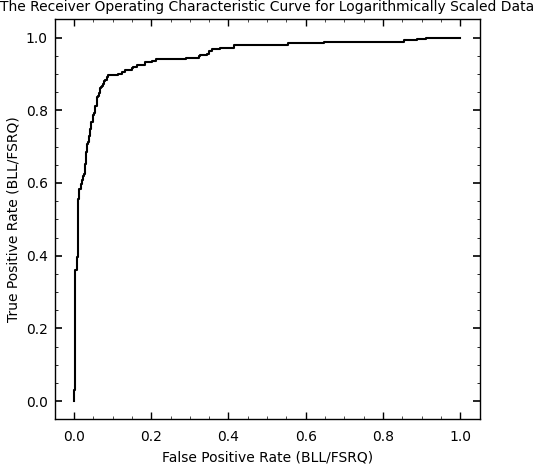

In [53]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', BNN)
])

# Fit the pipeline on the training data

BNN.fit(x_train,y_train)
y_pred = BNN.predict(x_test)
y_proba = BNN.predict_proba(x_test)


''' SCORING METRICS '''

accuracy = accuracy_score(y_test, y_pred)*100
confusion = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test,y_pred)
roc_auc_weightedavg = roc_auc_score(y_test,y_pred,average='weighted')
logloss = log_loss(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
fpr, tpr, thresholds = roc_curve(y_test,y_proba.T[1])

#print('The Neural Network accuracy is ' + str(accuracy))
#print('The Neural Network ROC AUC Scores are: '+str(roc_auc))
#print("The Neural Network's Weighted Average ROC AUC Score is: " + str(roc_auc_weightedavg))
#print("The Neural Network's Logarithmic Loss Score is: " + str(logloss))
#print('The Neural Network F1 Score is: '+str(f1))
#print('The Neural Network Confusion Matrix is:')
#print(confusion)

resultcols = ['Params','Accuracy', 'ROC AUC', 'ROC Weighted Av', 'Logarithmic Loss', 
              'F1 Score', 'CMatrix11','CMatrix12', 'CMatrix21', 'CMatrix22']
resultarray = np.array((clf.best_params_,accuracy,roc_auc,roc_auc_weightedavg,logloss,f1,
                        confusion[0,0],confusion[0,1],confusion[1,0],confusion[1,1]))
rocresultcols = ['FPR','TPR','Thresholds']
rocresultarray = np.array([fpr,tpr,thresholds])
print(rocresultarray.shape)
#print(rocresultarray)
results = pd.DataFrame([resultarray],columns=resultcols)
rocresults = pd.DataFrame(np.array([fpr,tpr,thresholds]).transpose(),columns=rocresultcols)

#results.to_csv('/content/drive/My Drive/Colab Notebooks/testresults.csv')
#rocresults.to_csv('/content/drive/My Drive/Colab Notebooks/testrocresults.csv')
results.to_csv('..\\Hyperparam_results\\2layer_0.csv')
rocresults.to_csv('..\\Hyperparam_results\\2layer_roc_0.csv')



mpl.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fpr,tpr)
ax.set_ylabel('True Positive Rate (BLL/FSRQ)')
ax.set_xlabel('False Positive Rate (BLL/FSRQ)')

#RocCurveDisplay.from_estimator(pipeline, x_test, y_test,ax=ax).figure_
plt.title('The Receiver Operating Characteristic Curve for Logarithmically Scaled Data')
plt.show()

In [54]:
dataclassles = data.drop(columns='CLASS1')
df_test = pd.DataFrame(x_test,columns=[dataclassles.columns])
df_test['CLASS1'] = y_test
df_test['y_pred'] = y_pred
df_test['y_probs_bll'] = y_proba.T[0]
df_test['y_probs_fsrq'] = y_proba.T[1]
df_test.to_csv('..\\Fermi-LAT Data\\ML_Results.csv')


(693, 14)


Text(0.5, 1.0, '')

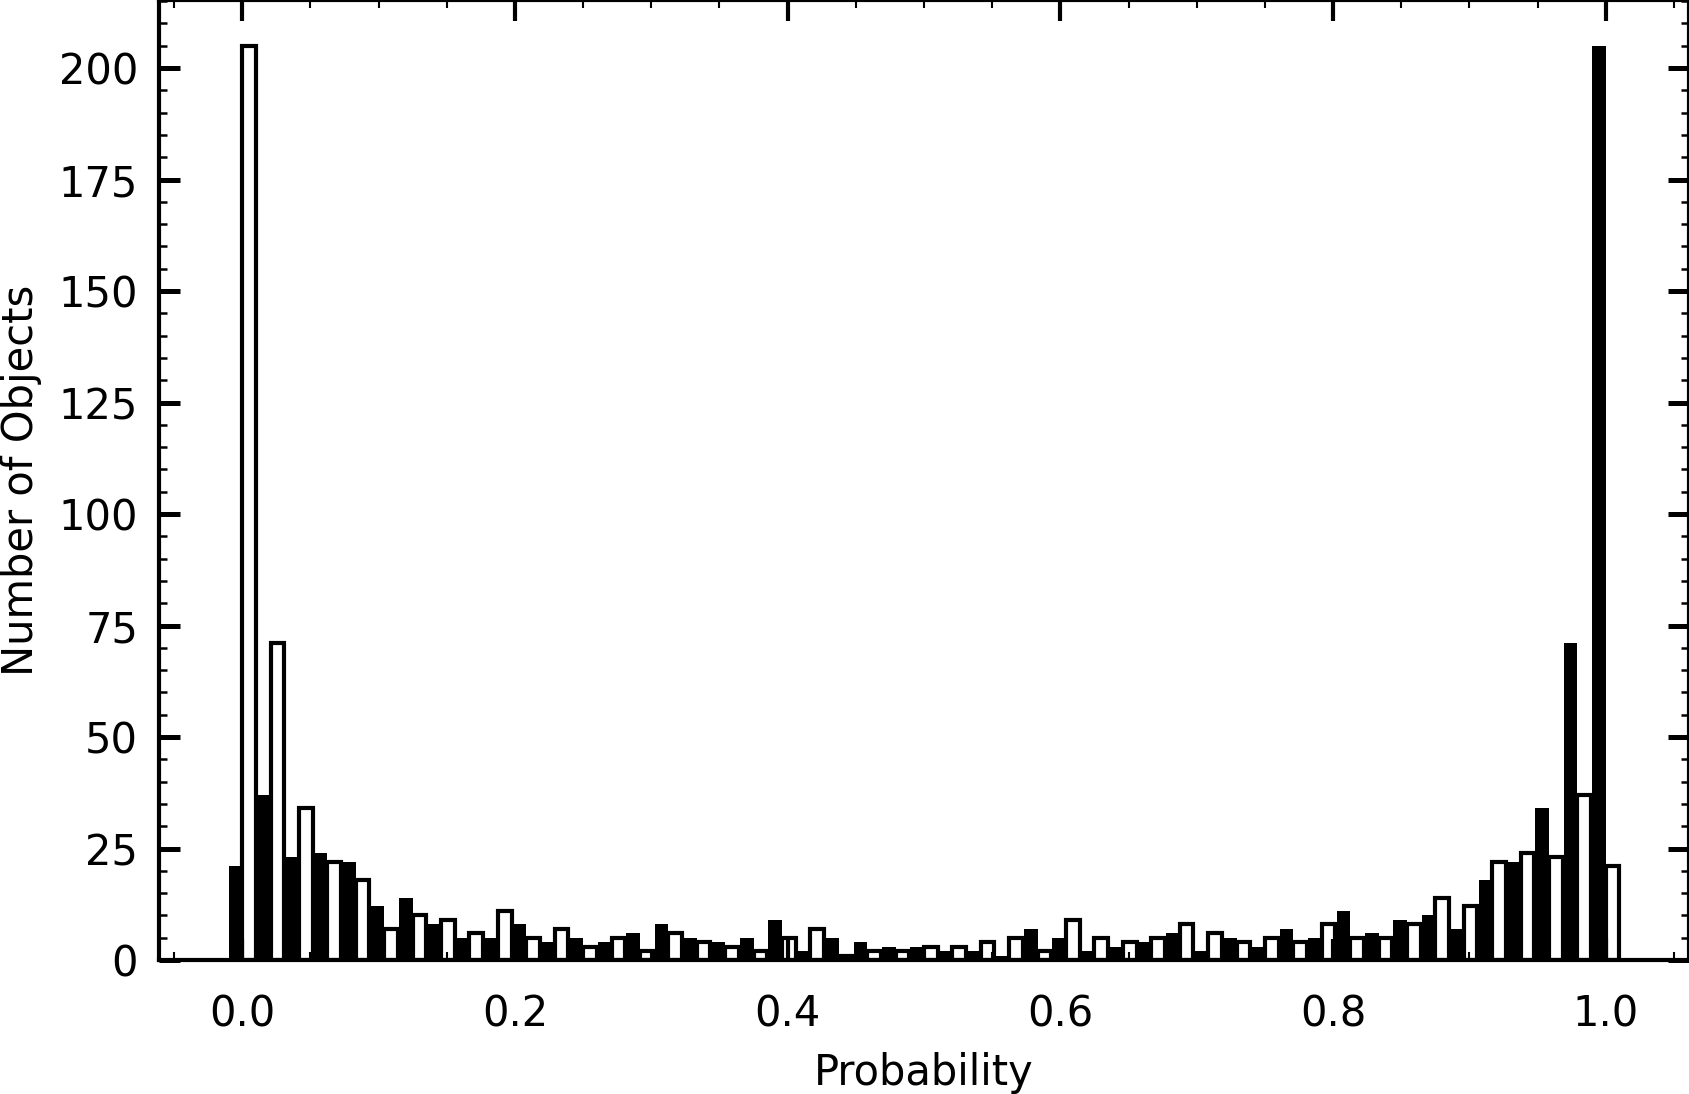

In [55]:
import matplotlib.pyplot as plt
#print(y_proba)
probs = pd.DataFrame(y_proba,columns=('p_1','p_2'))
bin_probs_1 = pd.cut(probs['p_1'],np.linspace(0,1,50),include_lowest=True)
bin_probs_2 = pd.cut(probs['p_2'],np.linspace(0,1,50),include_lowest=True)

print(x_test.shape)

fig, ax = plt.subplots(figsize=(6,4),dpi=300)
x_axis = np.linspace(0,1,len(bin_probs_1.value_counts()))

ax.bar(x_axis-0.005,bin_probs_1.value_counts(sort=False), width=0.01,label='BLLs')
ax.bar(x_axis+0.005,bin_probs_2.value_counts(sort=False),width=0.01,label='FSRQs',color='white',edgecolor='black')
#ax.legend()
ax.set_xlabel('Probability')
ax.set_ylabel('Number of Objects')
ax.set_title('')

#plt.show()

In [62]:
data = pd.read_csv(filepath, index_col=0)
X,Y = dp.choose_2_vars('CLASS1',data,1,2)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,random_state=4)
correct = np.array([])
incorrect = np.array([])
y_actual = np.array(y_pred)
print(len(y_pred))
print(len(x_test))

for i in range(0,len(y_pred)):
    if y_pred[i] == y_actual[i]:
        correct = np.append(correct,i)
    else:
        incorrect = np.append(incorrect, i)

inc_probs = np.array([])

for i in range(0,len(incorrect)):
    inc_probs = np.append(inc_probs, y_proba[0:int(incorrect[i])])

scaler = StandardScaler()  
rdgcount = 0
data_array = np.array(data) # all of x and y including radio galaxies
for i in range(0,len(data_array)):
    if data_array[i,0] == 3:  # if row number 'i' is a radio galaxy
        rdgcount +=1
        newrow = np.array(data_array[i])
        newrow = np.delete(newrow,0)
        x_test=np.append(x_test,[newrow],axis=0)   
        y_test = np.append(y_test,3)   
scaler.fit(x_train) 
x_test = scaler.transform(x_test)


693
693


C:\Users\ioanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [63]:
dataclassles = data.drop(columns='CLASS1')
df_test = pd.DataFrame(x_test,columns=[dataclassles.columns])
print(len(y_pred))
df_test['CLASS1'] = y_test
df_test['y_pred'] = y_pred
df_test['y_probs_bll'] = y_proba.T[0]
df_test['y_probs_fsrq'] = y_proba.T[1]
df_test.to_csv('..\\Fermi-LAT Data\\ML_Results_withrdg.csv')


693


ValueError: Length of values (693) does not match length of index (746)

In [64]:
data = pd.read_csv(filepath, index_col=0)
fig, ax = plt.subplots()
#plt.scatter(data['Frac_Variability'], data['HR_24'])
cols = data.columns

for j in range(0,len(cols)):
    for k in range(0,len(cols)):
        if j > k:     
            frac = np.array(data[cols[j]])
            hr = np.array(data[cols[k]])
            bllfrac=np.array([])
            bllhr = np.array([])
            fsrqfrac=np.array([])
            fsrqhr = np.array([])
            for i in range(0,len(y_pred)):
                if y_pred[i] == 0:
                    #print('bll')
                    bllfrac=np.append(bllfrac,frac[i])
                    bllhr=np.append(bllhr,hr[i])
                if y_pred[i] == 1:
                    #print('fsrq')
                    fsrqfrac=np.append(fsrqfrac,frac[i])
                    fsrqhr=np.append(fsrqhr,hr[i])

            plt.scatter(fsrqfrac,fsrqhr,color='red')
            plt.scatter(bllfrac,bllhr,color='blue')
            plt.savefig('autoplot_' + cols[j] + '_and_' + cols[k] + '.png')
            plt.clf()


<Figure size 600x300 with 0 Axes>

In [65]:
data = pd.read_csv('..\\Fermi-LAT Data\\fl_numericalonly_nopositional_withclasses.csv')


frac = np.array(data['Spectral_Index'])
hr = np.array(data['Flux1000'])
bllfrac=np.array([])
bllhr = np.array([])
fsrqfrac=np.array([])
fsrqhr = np.array([])
for i in range(0,len(y_pred)):
    if y_pred[i] == 0:
        #print('bll')
        bllfrac=np.append(bllfrac,frac[i])
        bllhr=np.append(bllhr,hr[i])
    if y_pred[i] == 1:
        #print('fsrq')
        fsrqfrac=np.append(fsrqfrac,frac[i])
        fsrqhr=np.append(fsrqhr,hr[i])

plt.scatter(fsrqfrac,fsrqhr,color='red')
plt.scatter(bllfrac,bllhr,color='blue')
plt.savefig('autoplot_' + cols[j] + '_and_' + cols[k] + '.png')
plt.clf()

KeyError: 'Spectral_Index'